<a href="https://colab.research.google.com/github/horti-stanford/cs230-milestone/blob/main/HME_StageA_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stage A
*   Feature detection CNN with the following layers
*   CNN with p = 3, f = 7, s = 1
*   Will set up: ZEROPAD2D -> CONV2D -> BN -> RELU -> MAXPOOL -> FLATTEN
*   Ref: Le & Nakagawa used 4 sets of (Conv->BN->RELU->MAXPOOL) followed by
*   (Conv->BN->RELU->Output)
*   We will just do 1 set of them for simplicity and easily repeat the layers
*   if needed later



In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
import os

In [2]:
np.random.seed(1)

In [3]:
# Mount drive with processed training data
from google.colab import drive

drive.mount('/cs230-root')

Mounted at /cs230-root


In [4]:
# Fetch and save list of training images (X)

train_dir = '/cs230-root/MyDrive/cs230-project/mathwriting-2024-excerpt/train-images/'
directory_files = os.listdir(train_dir)
n_training_files = len(directory_files)
# print # of files found
print("# of training data files: ", n_training_files)
# print sample file name
print("Sample file name:  ", directory_files[n_training_files - 1])

# of training data files:  100
Sample file name:   033bbf63000c086d.inkml.rgb


In [5]:
# Read files into arrays and stack into training set
# Read files into arrays
from PIL import Image
import numpy as np

def load_img_to_array(img_file):
  # Open the image file
  img = Image.open(img_file)
  # Convert the image to a NumPy array
  img_array = np.array(img)
  # print(img_array)
  return img_array

imgs = []
for i in range(len(directory_files)):
  f = train_dir+directory_files[i]
  #print("processing ", i, " : ",  f )
  imgs.append(load_img_to_array(f))
X_train_orig = np.stack(imgs)

In [6]:
# Normalize image vectors
X_train = X_train_orig/255
print ("Number of training examples = ", X_train.shape[0])
print ("X_train shape: ", X_train.shape)

Number of training examples =  100
X_train shape:  (100, 128, 256, 3)


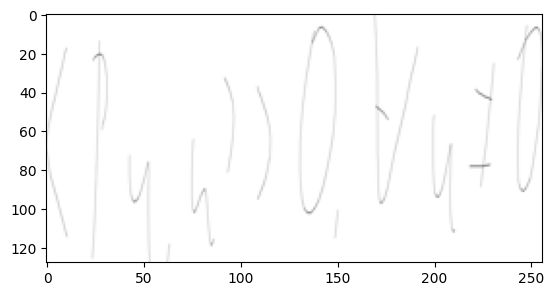

In [7]:
# Show sample image
index = 3
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

In [27]:
# LaTeX labels (training Y)
lbl_dir = '/cs230-root/MyDrive/cs230-project/mathwriting-2024-excerpt/train-labels/'
label_files = os.listdir(lbl_dir)
n_label_files = len(label_files)
# print # of files found
print("# of training label files: ", n_label_files)
# print sample file name
print("Sample file name:  ", label_files[n_label_files - 1])

# of training label files:  100
Sample file name:   073036bdd616605d.inkml.lbl


In [13]:
# Read LaTeX label files, tokenize them and save labels into array of lists of tokens
def load_labels_to_token_list(lbl_file):
  # Read label string
  with open(lbl_file, "r") as lbl:
    label = lbl.readline()
    # print(label)
  return label

In [14]:
# Tokenize (modified from Mathwriting paper's github)
import re

_COMMAND_RE = re.compile(r'\\(mathbb{[a-zA-Z]}|begin{[a-z]+}|end{[a-z]+}|operatorname\\*|[a-zA-Z]+|.)')

def tokenize_expression(s: str) -> list[str]:
  r"""Transform a Latex math string into a list of tokens.

  Tokens are strings that are meaningful in the context of Latex
  e.g. '1', r'\alpha', r'\frac'.

  Args:
    s: unicode input string (ex: r"\frac{1}{2}")

  Returns:
    tokens: list of tokens as unicode strings.
  """
  tokens = []
  while s:
    if s[0] == '\\' :
      tokens.append(_COMMAND_RE.match(s).group(0))
    else:
      tokens.append(s[0])

    s = s[len(tokens[-1]) :]

  return tokens


In [15]:
labels = []
for i in range(n_label_files):
  f = lbl_dir+label_files[i]
  labels.append(tokenize_expression(load_labels_to_token_list(f)))
Y_train = labels
print ("Number of training labels  = ", len(Y_train))
print("sample tokens [1]", Y_train[1])

Number of training labels  =  100
sample tokens [1] ['\\langle', ' ', 'P', 'u', ',', 'u', '\\rangle', '>', '0', ',', '\\forall', ' ', 'u', '\\ne', '0']


## Stage A


*   Feature detection CNN with the following layers
*   CNN with p = 3, f = 7, s = 1
*   Will set up: ZEROPAD2D -> CONV2D -> BN -> RELU -> MAXPOOL -> FLATTEN
*   Ref: Le & Nakagawa used 4 sets of (Conv->BN->RELU->MAXPOOL) followed by (Conv->BN->RELU->Output)
*   We will just do 1 set of them for simplicity




In [21]:
def StageAModel():
  """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BN -> RELU -> MAXPOOL -> FLATTEN -> Output features
    with p = 3, f = 7, s = 1
    n_f = 32

    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes.
    Normally, functions should take these values as function parameters.

    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process)
  """

  model = tf.keras.Sequential([
            tfl.Input(shape=(128, 256, 3)),
            ## Zero pad p = (f - 1)/2
            tfl.ZeroPadding2D(padding=(3, 3)),
            ## Conv2D with 32 7x7 filters and stride of 1
            tfl.Conv2D(filters=32, kernel_size=(7,7), strides = (1,1)),
            ## BatchNormalization for axis 3
            tfl.BatchNormalization(axis=3),
            ## ReLU
            tfl.ReLU(),
            ## Max Pooling 2D with default parameters
            tfl.MaxPooling2D()
     ])
  model.summary()
  return model

In [22]:
m = StageAModel()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 134, 262, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 256, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 256, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 128, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 128, 32)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,864 (19.00 KB)

 Trainable params: 4,800 (18.75 KB)

 Non-trainable params: 64 (256.00 B)

In [26]:
# Features are the output of the CNN which will be used as inputs to the
# encoder-decoder layer
sample_features = m.predict(X_train)
print(sample_features.shape)
sample_features_reshaped = sample_features.reshape(sample_features.shape[0],
                                                   -1, sample_features.shape[3])
print(sample_features_reshaped.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 331ms/step
(100, 64, 128, 32)
(100, 8192, 32)
